## Ribbon CNN Training Notebook

This notebook contains the code to train a simple CNN to classify different types of flare ribbons visible in 1600Å AIA (*Atmospheric Imaging Assembly*) images.

To use this notebook the following packages are needed:

(To train the network)
1. numpy

2. pickle (for reading in training data)

3. keras

4. scikit-learn

(To create training/test plots)
5. matplotlib

6. pandas

7. seaborn

Note that with the training data included in *4class_data.pickle* a GPU is currently not needed to train this model, however if the amount of data is increased this would have to change. 

The parameters chosen (epochs, batch size etc) are selected to optimize the network performance that corresponds to the training set, again if the training set is altered these may also have to be modified.

Note that in this notebook k-fold cross-validation has also been implemented (where k = 5), this is to ensure a more vigorus training of the model with varying validation sets used throughout training. For more information on cross validation please see [here](https://machinelearningmastery.com/k-fold-cross-validation/).


In [0]:
#training packages
import numpy as np
import pickle
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers
#plotting packages
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
import sklearn


We will initially read in the training and test data, with the model parameters also defined.

In [0]:
#Import data
with open('4class_data_training.pickle','rb') as t:
	 input_train, target_train = pickle.load(t)
	
with open('4class_data_test.pickle','rb') as t:
	 input_test, target_test = pickle.load(t)

In [0]:
# Model configuration
batch_size = 32
img_width, img_height, img_num_channels = 250, 250, 1
no_classes = 4
no_epochs = 10
validation_split = 0.4
verbosity = 1
num_folds = 5
input_shape = (img_width, img_height, img_num_channels)

In [0]:
# Define per-fold acc/loss lists
acc_per_fold = []
loss_per_fold = []
histories =[]
model_history = []

#Define training set
inputs = input_train
targets = target_train

K-fold cross-validation implemented below (the model code can be extracted from here is cross-validation is too computationally expensive).

In [11]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):  
# Define the model architecture  
	model = Sequential()  
	model.add(Convolution2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
	model.add(MaxPooling2D(pool_size=(2, 2)))  
	model.add(Convolution2D(64, kernel_size=(3, 3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Flatten())
	model.add(Dropout(0.5))
	model.add(Dense(128, activation='relu'))
	model.add(Dense(4, activation='softmax'))
	sgd = optimizers.sgd(lr=0.001, clipvalue=0.5)
	model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
	# Fit data to model
	history = model.fit(inputs[train], targets[train], batch_size=batch_size, epochs=no_epochs, verbose=verbosity, validation_split=validation_split)
	histories.append(history)
	model_history.append(model)
	# Generate generalization metrics
	scores = model.evaluate(inputs[test], targets[test], verbose=0)
	print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
	acc_per_fold.append(scores[1] * 100)
	loss_per_fold.append(scores[0])
	# Increase fold number
	fold_no = fold_no + 1
	# == Provide average scores ==
	print('------------------------------')
	print('Score per fold')
for i in range(0, len(acc_per_fold)):
	print('------------------------------')
	print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
	print('------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('-------------------------------')

Train on 257 samples, validate on 172 samples
Epoch 1/10
257/257 [==============================] - 26s 102ms/step - loss: 1.0505 - accuracy: 0.5331 - val_loss: 0.9217 - val_accuracy: 0.5640
Epoch 2/10
257/257 [==============================] - 22s 84ms/step - loss: 0.6815 - accuracy: 0.7082 - val_loss: 0.9235 - val_accuracy: 0.4651
Epoch 3/10
257/257 [==============================] - 21s 83ms/step - loss: 0.5282 - accuracy: 0.8210 - val_loss: 0.4924 - val_accuracy: 0.8372
Epoch 4/10
257/257 [==============================] - 21s 83ms/step - loss: 0.3554 - accuracy: 0.9183 - val_loss: 0.4095 - val_accuracy: 0.8547
Epoch 5/10
257/257 [==============================] - 22s 84ms/step - loss: 0.2970 - accuracy: 0.9300 - val_loss: 0.3761 - val_accuracy: 0.8837
Epoch 6/10
257/257 [==============================] - 21s 83ms/step - loss: 0.2423 - accuracy: 0.9377 - val_loss: 0.3607 - val_accuracy: 0.8605
Epoch 7/10
257/257 [==============================] - 21s 83ms/step - loss: 0.2210 - accu

The model is now sufficently trained - the plotting routines listed below are just some examples of how the model can be tested and results plotted.

First, the results from the cross-validation are plotted.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


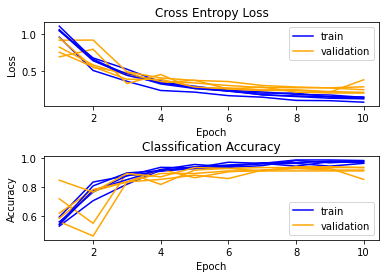

In [20]:
 for i in range(len(histories)):
     # plot loss
     plt.subplot(211)
     plt.title('Cross Entropy Loss')
     plt.plot(range(1, 11), histories[i].history['loss'], color='blue', label='train')
     plt.plot(range(1, 11), histories[i].history['val_loss'],color='orange', label='validation')
     plt.xlabel('Epoch')
     plt.ylabel('Loss')
     if i==0:
         plt.legend()
     # plot accuracy
     plt.subplot(212)
     plt.title('Classification Accuracy')
     plt.plot(range(1, 11), histories[i].history['accuracy'], color='blue', label='train')
     plt.plot(range(1, 11), histories[i].history['val_accuracy'], color='orange', label='validation')
     plt.xlabel('Epoch')
     plt.ylabel('Accuracy')
     if i ==0:
         plt.legend()
plt.subplots_adjust(hspace = 0.6)

A confusion matrix using the test data set is created below. 

Text(33.0, 0.5, 'True Class')

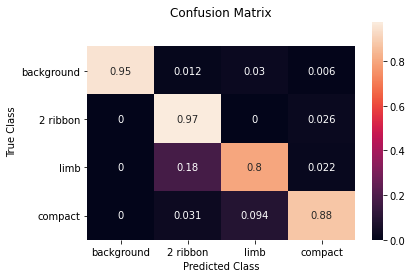

In [23]:
#test trained model.
testout = model.predict(input_test)

matrix = sklearn.metrics.confusion_matrix(testout.argmax(axis=1), np.array(target_test))
normmatrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

classes = ['background', '2 ribbon', 'limb', 'compact']
df_cm = pd.DataFrame(normmatrix, index = classes,columns = classes)
ax= plt.subplot()
sn.heatmap(df_cm, annot=True)
ax.set_ylim(len(matrix), -0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

